Imports

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

Retrieving bitcoin prices

In [46]:
df = yf.download('BTC-USD')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


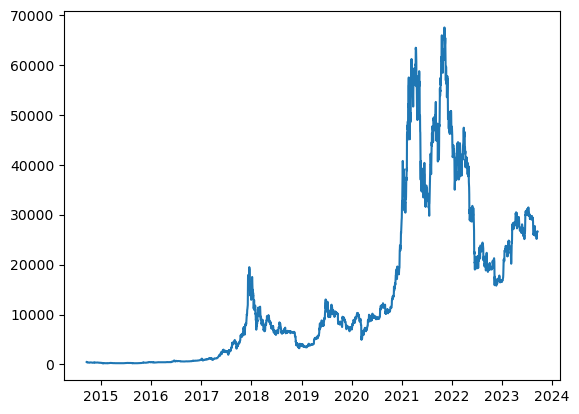

In [47]:
plt.plot(df.index, df['Adj Close'])
plt.show()

In [48]:
to_row = int(len(df) * 0.75)

training_data = list(df[0:to_row]['Adj Close'])
testing_data = list(df[to_row:]['Adj Close'])

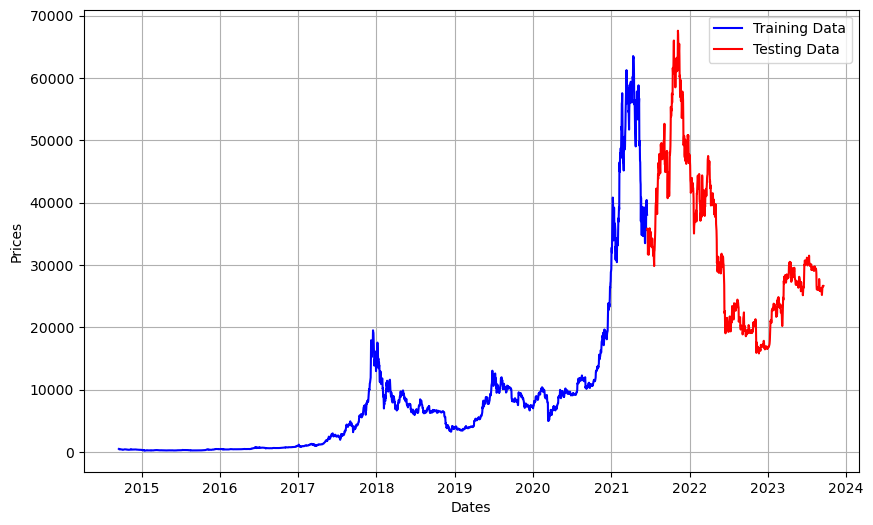

In [49]:
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.plot(df[0:to_row]['Adj Close'], 'blue', label='Training Data')
plt.plot(df[to_row:]['Adj Close'], 'red', label='Testing Data')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

plt.show()

Using ADF test to get p-values and check stationarity

In [50]:
result = sm.tsa.adfuller(df['Adj Close'])
adf = result[0]
pvalue = result[1]

print(f'ADF Statistic: {adf}')
print(f'p-value: {pvalue}')

ADF Statistic: -1.618317369041028
p-value: 0.47361154654314175


Apply n order differencing to get a p-value < 0.001

In [55]:
df['Differenced'] = df['Adj Close'].diff(periods=1)

df.dropna(inplace=True)

result = sm.tsa.adfuller(df['Differenced'])
adf = result[0]
pvalue = result[1]

print(f'ADF Statistic: {adf}')
print(f'p-value: {pvalue}')

ADF Statistic: -9.603826134766798
p-value: 1.8893492669576757e-16


PACF and ACF

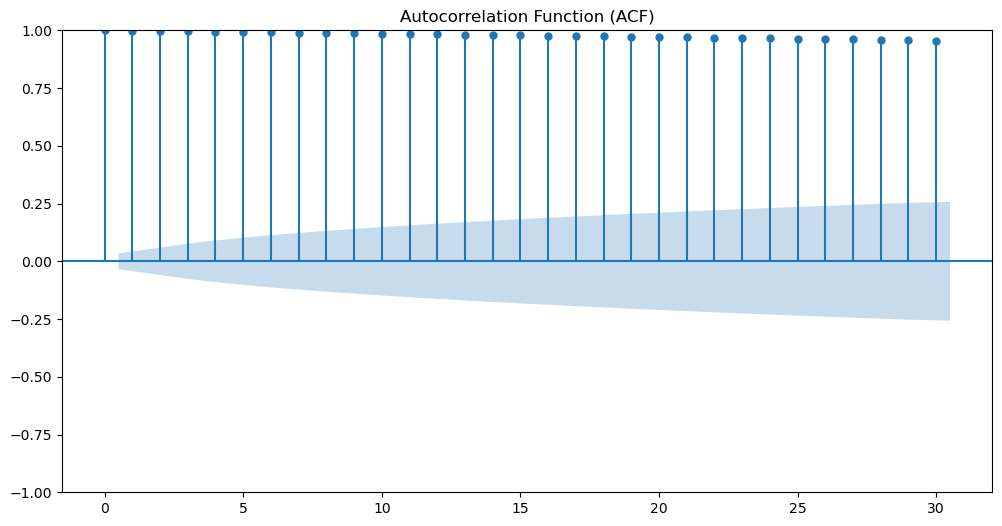

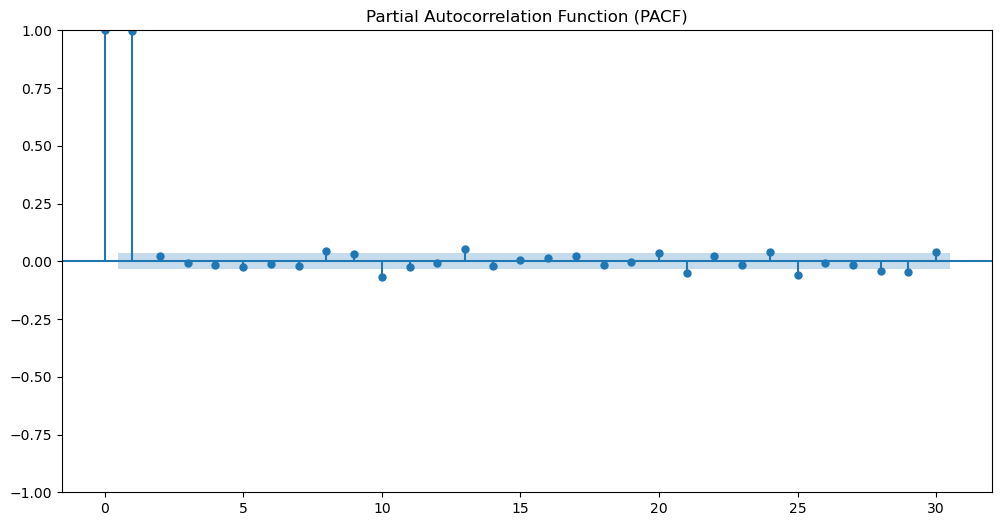

In [61]:
# ACF(q value)
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_acf(df['Adj Close'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF(p value)
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(df['Adj Close'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()